In [39]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Загрузка

In [40]:
raw_data = pd.read_parquet("..\\Data\\raw\\dataset.parquet")
raw_data.head()

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,0,0,999999999,999999999,0,0.0,975.686105,958.353127,1.174111,1.153253,61.680231,0.060948,58.317987,0.000001,44.479139,0.000000,31.575270,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,6,44.410991,4026.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,0,0,999999999,999999999,0,0.0,975.686105,958.510238,1.171292,1.150673,61.680231,0.060948,58.317987,0.004953,44.479139,44.479139,31.418863,31.575270,0.000000,0.0,0.000001,0.000001,0.157110,0.157110,1,0.0,0.0,0,0.157110,6,44.410991,4165.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,0,0,999999999,999999999,0,0.0,975.686105,958.896402,1.168486,1.148379,61.680231,0.060948,58.317987,0.017103,44.479139,44.479139,31.035236,31.497067,0.000387,0.0,0.002477,0.004953,0.543275,0.271637,2,0.0,0.0,0,0.543275,6,44.410991,4215.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,0,0,999999999,999999999,0,0.0,0.103772,0.803077,0.001596,0.012355,0.000000,0.000000,0.000000,0.000001,0.000767,0.000000,0.000460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,1,0.000772,7661.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.4065

# Создание фичей

## Квантование численных признаков

Создадим класс, который будет квантовать столбец по его названию

In [3]:
import pandas as pd
import pickle
from sklearn.preprocessing import QuantileTransformer


class QuantileFeatureTransformer:
    def __init__(self, output_distribution='normal', n_quantiles=1000, random_state=None):
        self.transformers = {}  # словарь: имя столбца -> QuantileTransformer
        self.output_distribution = output_distribution
        self.n_quantiles = n_quantiles
        self.random_state = random_state

    def fit_transform(self, series: pd.Series) -> pd.Series:
        col_name = series.name
        if col_name not in self.transformers:
            qt = QuantileTransformer(
                output_distribution=self.output_distribution,
                n_quantiles=min(self.n_quantiles, series.shape[0]),  # не больше длины серии
                random_state=self.random_state
            )
            transformed = qt.fit_transform(series.values.reshape(-1, 1)).flatten()
            self.transformers[col_name] = qt
            return pd.Series(transformed, name=col_name, index=series.index)
        else:
            return self.transform(series)

    def transform(self, series: pd.Series) -> pd.Series:
        col_name = series.name
        if col_name not in self.transformers:
            raise ValueError(f"No transformer found for column '{col_name}'. Fit first.")
        qt = self.transformers[col_name]
        transformed = qt.transform(series.values.reshape(-1, 1)).flatten()
        return pd.Series(transformed, name=col_name, index=series.index)

    def save(self, filepath: str):
        """Сохраняет словарь трансформеров в файл"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.transformers, f)

    def load(self, filepath: str):
        """Загружает словарь трансформеров из файла"""
        with open(filepath, 'rb') as f:
            self.transformers = pickle.load(f)

In [4]:
quantile_transformer = QuantileFeatureTransformer()

In [6]:
numeric_columns = raw_data.select_dtypes(include=["number"]).columns.to_list()
numeric_columns.remove("target")
numeric_columns[:5]

['borrow_block_number',
 'borrow_timestamp',
 'first_tx_timestamp',
 'last_tx_timestamp',
 'wallet_age']

In [10]:
%%time
for col in numeric_columns:
    raw_data[col+"_qt"] = quantile_transformer.fit_transform(raw_data[col])

CPU times: total: 4.73 s
Wall time: 4.73 s


Пример квантования

In [17]:
raw_data.iloc[:5, -8:]

,market_natr_qt,market_plus_di_qt,market_plus_dm_qt,market_ppo_qt,market_rocp_qt,market_rocr_qt,unique_borrow_protocol_count_qt,unique_lending_protocol_count_qt
0,-0.592184,1.086885,-1.364775,-0.563431,0.506216,0.511818,-5.199338,-0.282216
1,-0.592184,1.086885,-1.364775,-0.563431,0.506216,0.511818,0.032625,-0.282216
2,-0.592184,1.086885,-1.364775,-0.563431,0.506216,0.511818,0.032625,-0.282216
3,-0.592184,1.086885,-1.364775,-0.563431,0.506216,0.511818,-5.199338,-0.282216
4,-0.592184,1.086885,-1.364775,-0.563431,0.506216,0.511818,-5.199338,-0.282216


Посмотрим как коррелируют наши значения с таргетом

In [29]:
need_columns = raw_data.columns[-76:].to_list()
need_columns.append("target")
need_columns[:3]

['borrow_block_number_qt', 'borrow_timestamp_qt', 'first_tx_timestamp_qt']

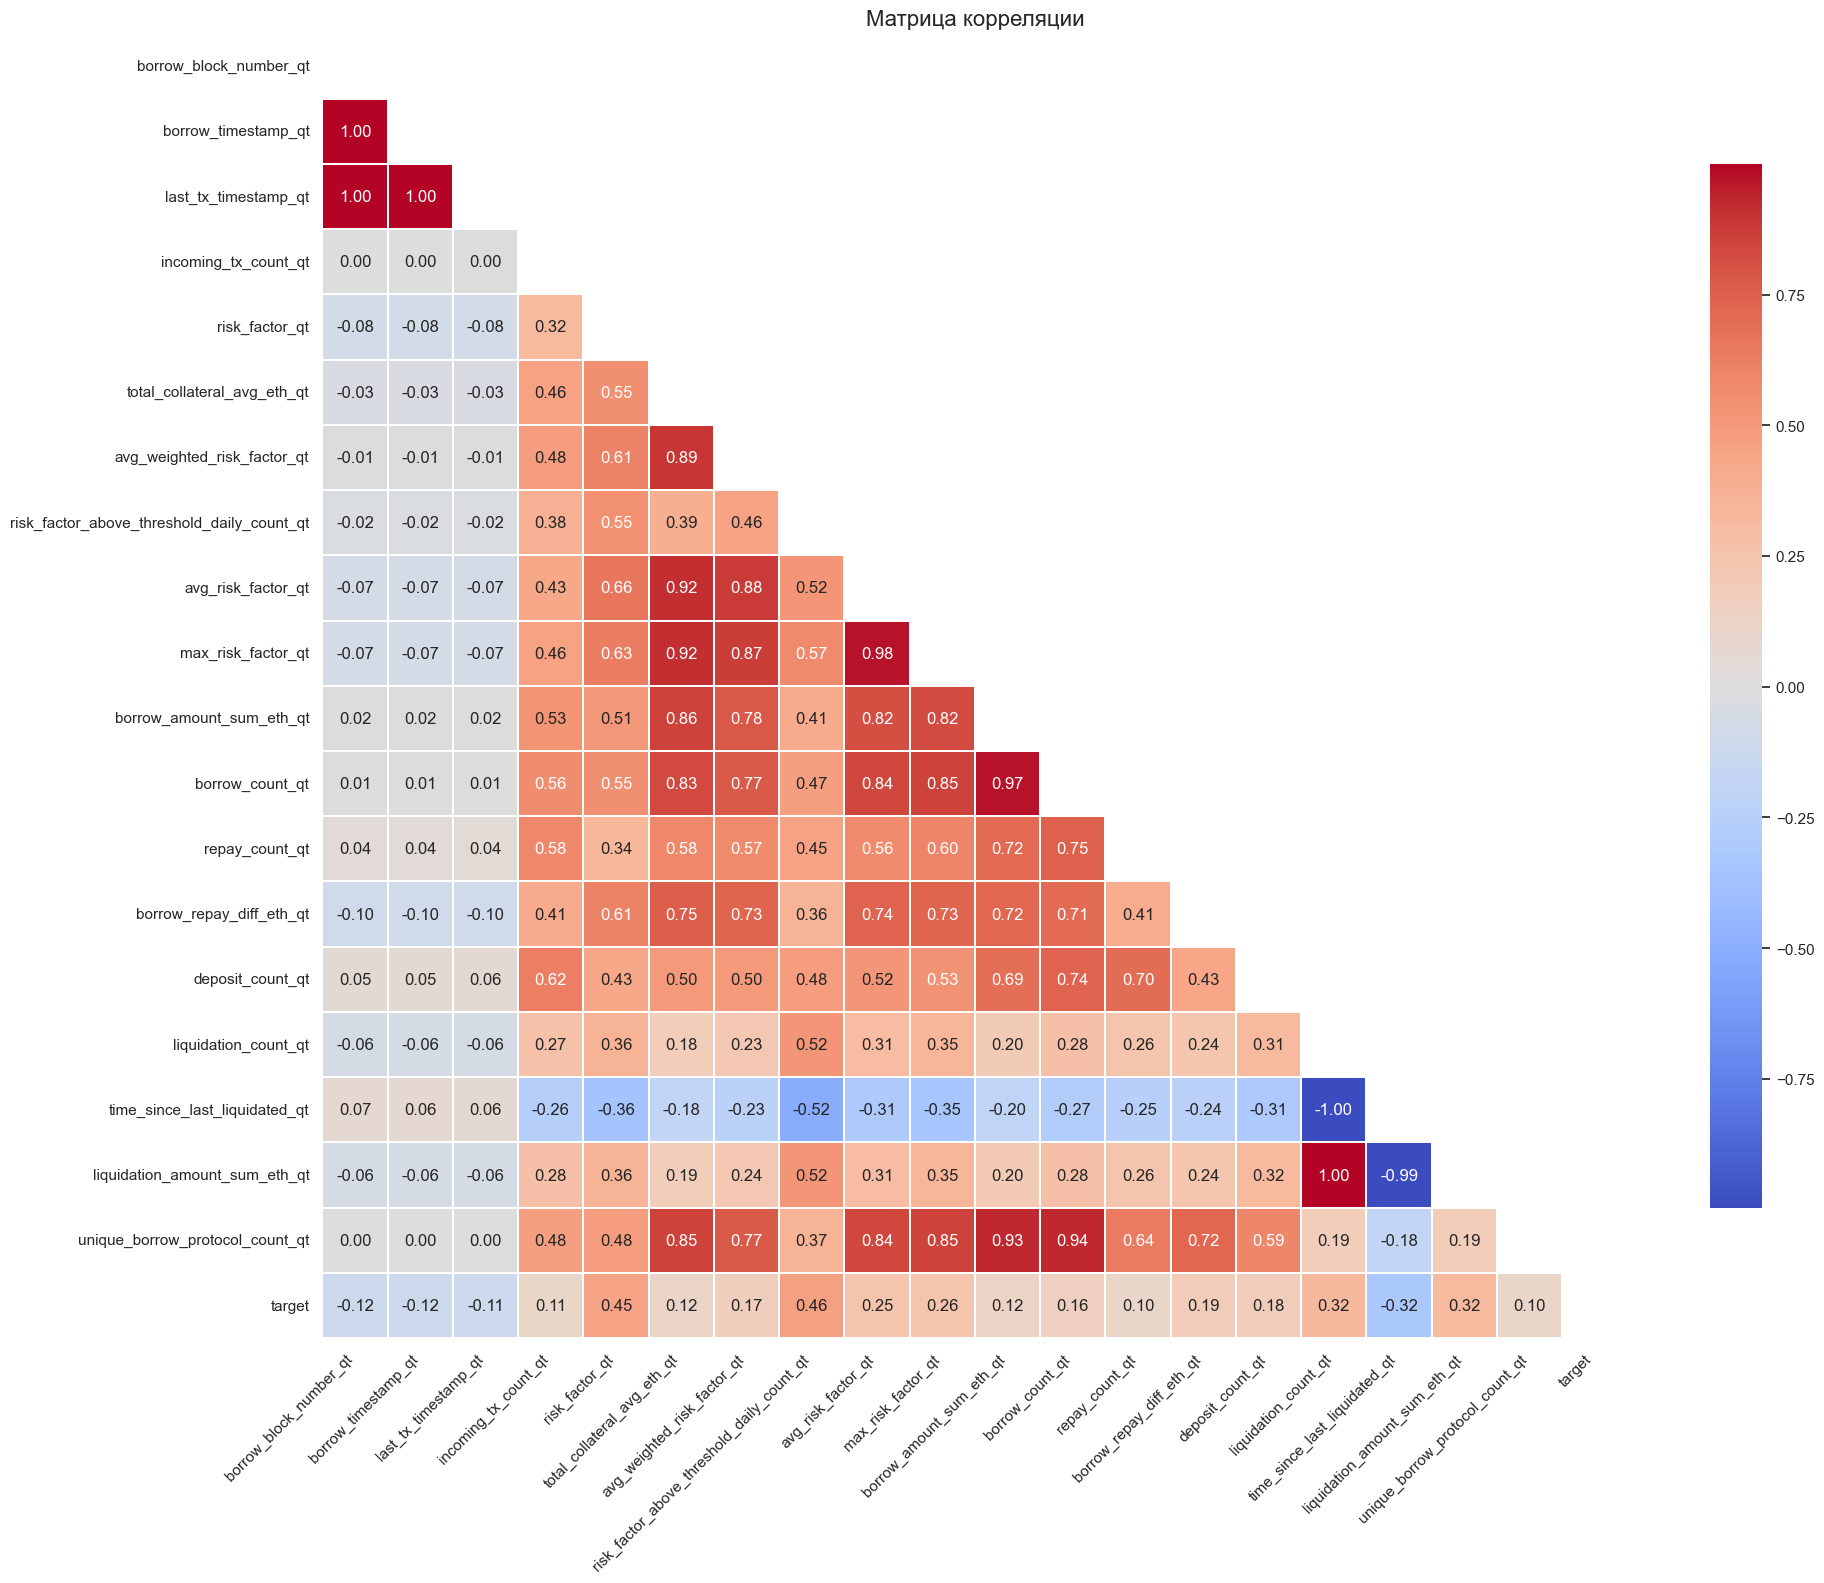

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np

numeric_df = raw_data[need_columns]
# Вычисляем корреляцию всех признаков с target
correlation_with_target = numeric_df.corr()['target'].drop('target')

# Фильтруем признаки с высокой корреляцией по модулю
threshold = 0.1  # можно увеличить до 0.5 или уменьшить до 0.2
strong_corr_features = correlation_with_target[correlation_with_target.abs() > threshold].index.tolist()

# Добавляем сам таргет для построения полной матрицы
selected_columns = strong_corr_features + ['target']

# Вычисляем корреляцию
corr = numeric_df[selected_columns].corr()

# Создаем маску для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Размер графика
plt.figure(figsize=(20, 16))
sns.set(style="white")

# Рисуем тепловую карту
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",        # цветовая карта (можно поменять)
    annot=True,             # подписи чисел
    fmt=".2f",              # формат чисел
    linewidths=0.1,         # линии между ячейками
    square=True,            # квадратные ячейки
    cbar_kws={"shrink": 0.8}  # легенда
)

plt.title("Матрица корреляции", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Конечно, большинство значений никак не коррелируют с таргетом, но у некоторых перменных есть явная связь с таргетом. 0.3 - 0.4 относительно хорошая корреляция

## Извлечение фичей о времени

In [47]:
import pandas as pd
import numpy as np

class TimestampFeatureExtractor:
    AVAILABLE_FEATURES = {
        'year', 'month', 'day', 'dayofweek', 'day_name', 'dayofyear',
        'week', 'quarter', 'hour', 'minute', 'second',
        'is_weekend', 'hour_sin', 'hour_cos'
    }

    def __init__(self, ts_series: pd.Series, features: list[str] = None):
        if not pd.api.types.is_numeric_dtype(ts_series):
            raise ValueError("Input must be a numeric pandas Series (e.g., UNIX timestamps in seconds)")
        
        self.series = pd.to_datetime(ts_series, unit='s')
        self.prefix = ts_series.name or 'timestamp'

        if features is None:
            self.features = list(self.AVAILABLE_FEATURES)
        else:
            unknown = set(features) - self.AVAILABLE_FEATURES
            if unknown:
                raise ValueError(f"Unknown features: {unknown}")
            self.features = list(features)

    def extract(self) -> pd.DataFrame:
        dt = self.series
        prefix = self.prefix
        result = {}

        for feat in self.features:
            col_name = f'{prefix}_{feat}'

            if feat == 'year':
                result[col_name] = dt.dt.year
            elif feat == 'month':
                result[col_name] = dt.dt.month
            elif feat == 'day':
                result[col_name] = dt.dt.day
            elif feat == 'dayofweek':
                result[col_name] = dt.dt.dayofweek
            elif feat == 'day_name':
                result[col_name] = dt.dt.day_name()  # или можно .astype('category').cat.codes
            elif feat == 'dayofyear':
                result[col_name] = dt.dt.dayofyear
            elif feat == 'week':
                result[col_name] = dt.dt.isocalendar().week
            elif feat == 'quarter':
                result[col_name] = dt.dt.quarter
            elif feat == 'hour':
                result[col_name] = dt.dt.hour
            elif feat == 'minute':
                result[col_name] = dt.dt.minute
            elif feat == 'second':
                result[col_name] = dt.dt.second
            elif feat == 'is_weekend':
                result[col_name] = (dt.dt.dayofweek >= 5).astype(int)
            elif feat == 'hour_sin':
                result[col_name] = np.sin(2 * np.pi * dt.dt.hour / 24)
            elif feat == 'hour_cos':
                result[col_name] = np.cos(2 * np.pi * dt.dt.hour / 24)

        return pd.DataFrame(result)


In [48]:
timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]

In [49]:
for timestamp_col in timestamp_columns:
    # Извлечение
    extractor = TimestampFeatureExtractor(raw_data[timestamp_col])
    timestamp_features = extractor.extract()

    # Объединяем с основным датафреймом
    raw_data = pd.concat([raw_data, timestamp_features], axis=1)

In [50]:
raw_data.iloc[:5, -8:]

,risky_last_tx_timestamp_dayofweek,risky_last_tx_timestamp_quarter,risky_last_tx_timestamp_month,risky_last_tx_timestamp_is_weekend,risky_last_tx_timestamp_dayofyear,risky_last_tx_timestamp_hour_sin,risky_last_tx_timestamp_day_name,risky_last_tx_timestamp_day
0,6,3,9,1,252,0.258819,Sunday,9
1,6,3,9,1,252,0.258819,Sunday,9
2,6,3,9,1,252,0.258819,Sunday,9
3,6,3,9,1,252,0.258819,Sunday,9
4,6,3,9,1,252,0.258819,Sunday,9


# Полный процесс извлечения фичей

In [88]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
import joblib

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    AVAILABLE_TS_FEATURES = {
        'year', 'month', 'day', 'dayofweek', 'day_name', 'dayofyear',
        'week', 'quarter', 'hour', 'minute', 'second',
        'is_weekend', 'hour_sin', 'hour_cos'
    }

    CATEGORICAL_TS_FEATURES = {'day_name', 'month', 'year', 'quarter'}

    def __init__(self,
                 timestamp_columns=None,
                 timestamp_features=None,
                 numeric_columns=None,
                 quantile_output_distribution='uniform',
                 quantile_n_quantiles=1000,
                 random_state=42):
        self.timestamp_columns = timestamp_columns or []
        self.timestamp_features = set(timestamp_features) if timestamp_features else self.AVAILABLE_TS_FEATURES
        self.numeric_columns = numeric_columns
        self.quantile_output_distribution = quantile_output_distribution
        self.quantile_n_quantiles = quantile_n_quantiles
        self.random_state = random_state

        self.quantile_transformers = {}

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # Определим числовые колонки, исключая timestamp
        if self.numeric_columns is None:
            self.numeric_columns_ = X.select_dtypes(include=[np.number]).columns.difference(self.timestamp_columns).tolist()
        else:
            self.numeric_columns_ = [col for col in self.numeric_columns if col not in self.timestamp_columns]

        # Обучим QuantileTransformer по числовым колонкам
        for col in self.numeric_columns_:
            qt = QuantileTransformer(
                output_distribution=self.quantile_output_distribution,
                n_quantiles=min(self.quantile_n_quantiles, X.shape[0]),
                random_state=self.random_state
            )
            qt.fit(X[[col]])
            self.quantile_transformers[col] = qt

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        result = pd.DataFrame(index=X.index)

        # Преобразуем числовые признаки
        for col in self.numeric_columns_:
            qt = self.quantile_transformers.get(col)
            if qt:
                result[f'{col}_qt'] = qt.transform(X[[col]]).flatten()

        # Временные признаки
        for col in self.timestamp_columns:
            ts = pd.to_datetime(X[col], unit='s')
            prefix = col
            temp = {}

            # Сначала извлечём все timestamp признаки
            if 'year' in self.timestamp_features:
                temp[f'{prefix}_year'] = ts.dt.year
            if 'month' in self.timestamp_features:
                temp[f'{prefix}_month'] = ts.dt.month
            if 'day' in self.timestamp_features:
                temp[f'{prefix}_day'] = ts.dt.day
            if 'dayofweek' in self.timestamp_features:
                temp[f'{prefix}_dayofweek'] = ts.dt.dayofweek
            if 'day_name' in self.timestamp_features:
                temp[f'{prefix}_day_name'] = ts.dt.day_name()
            if 'dayofyear' in self.timestamp_features:
                temp[f'{prefix}_dayofyear'] = ts.dt.dayofyear
            if 'week' in self.timestamp_features:
                temp[f'{prefix}_week'] = ts.dt.isocalendar().week
            if 'quarter' in self.timestamp_features:
                temp[f'{prefix}_quarter'] = ts.dt.quarter
            if 'hour' in self.timestamp_features:
                temp[f'{prefix}_hour'] = ts.dt.hour
            if 'minute' in self.timestamp_features:
                temp[f'{prefix}_minute'] = ts.dt.minute
            if 'second' in self.timestamp_features:
                temp[f'{prefix}_second'] = ts.dt.second
            if 'is_weekend' in self.timestamp_features:
                temp[f'{prefix}_is_weekend'] = (ts.dt.dayofweek >= 5).astype(int)
            if 'hour_sin' in self.timestamp_features:
                temp[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * ts.dt.hour / 24)
            if 'hour_cos' in self.timestamp_features:
                temp[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * ts.dt.hour / 24)

            temp_df = pd.DataFrame(temp)

            # One-hot-кодирование для категориальных timestamp признаков
            cat_features = [f'{prefix}_{f}' for f in self.CATEGORICAL_TS_FEATURES if f in self.timestamp_features]
            temp_df = pd.get_dummies(temp_df, columns=cat_features, drop_first=True, dtype=int)

            result = pd.concat([result, temp_df], axis=1)

        return result

    def save(self, path: str):
        joblib.dump(self, path)

    @staticmethod
    def load(path: str):
        return joblib.load(path)

In [89]:
timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]

In [90]:
numeric_columns = raw_data.select_dtypes(include=["number"]).columns.to_list()
numeric_columns = [col for col in numeric_columns if col not in timestamp_columns]
numeric_columns.remove("target")
numeric_columns[:10]

['borrow_block_number',
 'wallet_age',
 'incoming_tx_count',
 'outgoing_tx_count',
 'net_incoming_tx_count',
 'total_gas_paid_eth',
 'avg_gas_paid_per_tx_eth',
 'risky_tx_count',
 'risky_unique_contract_count',
 'risky_first_last_tx_timestamp_diff']

In [91]:
feature_preproc = FeaturePreprocessor(timestamp_columns=timestamp_columns, numeric_columns=numeric_columns)

In [92]:
raw_data = pd.read_parquet("..\\Data\\raw\\dataset.parquet")
raw_data.head()

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,0.000981,0,0,999999999,999999999,0,0.0,975.686105,958.353127,1.174111,1.153253,61.680231,0.060948,58.317987,0.000001,44.479139,0.000000,31.575270,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,6,44.410991,4026.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,0.000983,0,0,999999999,999999999,0,0.0,975.686105,958.510238,1.171292,1.150673,61.680231,0.060948,58.317987,0.004953,44.479139,44.479139,31.418863,31.575270,0.000000,0.0,0.000001,0.000001,0.157110,0.157110,1,0.0,0.0,0,0.157110,6,44.410991,4165.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,0.000985,0,0,999999999,999999999,0,0.0,975.686105,958.896402,1.168486,1.148379,61.680231,0.060948,58.317987,0.017103,44.479139,44.479139,31.035236,31.497067,0.000387,0.0,0.002477,0.004953,0.543275,0.271637,2,0.0,0.0,0,0.543275,6,44.410991,4215.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.406507,-3.468973,1.163425,1.212219,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,0.010786,0,0,999999999,999999999,0,0.0,0.103772,0.803077,0.001596,0.012355,0.000000,0.000000,0.000000,0.000001,0.000767,0.000000,0.000460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0,0.000000,1,0.000772,7661.0,0.0,0.0,0,999999999.0,0.0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.02392,80.653832,57.459322,1,0.423859,-3.914837,1.326453,1.4065

In [93]:
sample = raw_data.sample(10)
sample

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
229427,12775538,1.625597e+09,0x400af1ad7ee1b84e89f133b76eb6e2eeba225bcb,1.623966e+09,1.625596e+09,1630742.0,4,2,2,0.024753,0.012377,1,1,1625593468,1625593468,0,15.275400,15.275400,14.780318,2.182200,2.111474,19.619813,15.170495,15.275400,0.000001,48.284050,0.000000,41.041443,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,1,15.275400,3037.0,0.000000,0.0,0,999999999.0,0.0,24.349703,27.303152,-103.092252,-45.555556,92.857143,209.606283,82.522074,-3.083475,0.970451,1.181477,48.765849,69.909320,1,32.408068,-103.092252,-66.466681,-68.786382,-218.051225,-114.147691,-119.086798,-0.608560,10.304572,21.986189,628.489420,-4.690995,0.212531,1.212531,0,1,0
386140,15931602,1.667986e+09,0x49a4cbd1a9a166206ea8133a3bb40cb0188c3144,1.614998e+09,1.664862e+09,52988569.0,56,65,-9,0.395536,0.006085,2,2,1663491047,1663491131,84,4.481813,33.796036,40.859275,0.212554,0.256977,4.718801,0.002190,0.133751,0.344875,5.610562,8.346016,3.050766,4.622443,0.767677,0.0,0.335872,0.440304,1.285649,1.285649,1,0.000000,0.000000,0,1.285649,3,10.146097,4749768.0,4.541225,0.0,0,999999999.0,0.0,29.451800,26.772357,127.625697,-65.555556,78.571429,94.101472,15.143329,16.642575,0.971715,16.426069,35.698913,51.950135,1,5.395913,127.625697,59.201232,62.009550,111.876801,53.959082,56.717874,-0.816810,5.424600,28.988749,263.001840,8.818789,0.008430,1.008430,1,1,0
14180,8906096,1.573356e+09,0xa4003d6f5f41904bbc6a76ab1cd9c8371548a8e8,1.494619e+09,1.573355e+09,78736677.0,191,371,-180,0.798581,0.002147,0,0,999999999,999999999,0,0.000000,32.110345,32.008476,0.045806,0.045661,2.383157,0.000578,0.280124,0.000001,0.083569,0.213333,0.062677,0.104898,0.029090,0.0,0.434216,0.818912,0.312500,0.052083,6,0.314063,0.062813,5,0.000000,21,2.482742,13383637.0,2.127990,0.0,0,999999999.0,0.0,18.937393,19.397261,5.712207,-7.777778,0.000000,10.079361,-23.816054,4.154936,0.801305,10.655694,22.600176,34.135259,1,0.190371,5.712207,1.795733,1.884325,2.939148,1.338190,1.414581,-0.612686,5.189489,23.727058,23.404469,3.165760,0.001822,1.001822,1,1,0
146704,11972604,1.614872e+09,0x9eba93dbc6a742e99b3e60135104cc5859eeaf0b,1.607795e+09,1.614870e+09,7076515.0,18,28,-10,0.203980,0.007555,0,0,999999999,999999999,0,0.000000,31.321671,33.576595,0.626433,0.671532,10.574672,0.026315,9.503023,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.0,0.000000,0.0,0,999999999.0,0.0,28.917215,28.884930,-101.107010,81.

In [94]:
feature_preproc.fit(sample)

FeaturePreprocessor(numeric_columns=['borrow_block_number', 'wallet_age',
                                     'incoming_tx_count', 'outgoing_tx_count',
                                     'net_incoming_tx_count',
                                     'total_gas_paid_eth',
                                     'avg_gas_paid_per_tx_eth',
                                     'risky_tx_count',
                                     'risky_unique_contract_count',
                                     'risky_first_last_tx_timestamp_diff',
                                     'risky_sum_outgoing_amount_eth',
                                     'outgoing_tx_sum_eth',
                                     'incoming_tx_sum_eth',
                                     'outgoi...
                                     'borrow_amount_sum_eth',
                                     'borrow_amount_avg_eth', 'borrow_count', ...],
                    timestamp_columns=['borrow_timestamp', 'first_tx_timestamp',
                                       'last_tx_timestamp',
                                       'risky_first_tx_timestamp',
                                       'risky_last_tx_timestamp'],
                    timestamp_features={'day', 'day_name', 'dayofweek',
                                        'dayofyear', 'hour', 'hour_cos',
                                        'hour_sin', 'is_weekend', 'minute',
                                        'month', 'quarter', 'second', 'week',
                                        'year'})

In [96]:
new_features = feature_preproc.transform(sample)
new_features

,borrow_block_number_qt,wallet_age_qt,incoming_tx_count_qt,outgoing_tx_count_qt,net_incoming_tx_count_qt,total_gas_paid_eth_qt,avg_gas_paid_per_tx_eth_qt,risky_tx_count_qt,risky_unique_contract_count_qt,risky_first_last_tx_timestamp_diff_qt,risky_sum_outgoing_amount_eth_qt,outgoing_tx_sum_eth_qt,incoming_tx_sum_eth_qt,outgoing_tx_avg_eth_qt,incoming_tx_avg_eth_qt,max_eth_ever_qt,min_eth_ever_qt,total_balance_eth_qt,risk_factor_qt,total_collateral_eth_qt,total_collateral_avg_eth_qt,total_available_borrows_eth_qt,total_available_borrows_avg_eth_qt,avg_weighted_risk_factor_qt,risk_factor_above_threshold_daily_count_qt,avg_risk_factor_qt,max_risk_factor_qt,borrow_amount_sum_eth_qt,borrow_amount_avg_eth_qt,borrow_count_qt,repay_amount_sum_eth_qt,repay_amount_avg_eth_qt,repay_count_qt,borrow_repay_diff_eth_qt,deposit_count_qt,deposit_amount_sum_eth_qt,time_since_first_deposit_qt,withdraw_amount_sum_eth_qt,withdraw_deposit_diff_if_positive_eth_qt,liquidation_count_qt,time_since_last_liquidated_qt,liquidation_amount_sum_eth_qt,market_adx_qt,market_adxr_qt,market_apo_qt,market_aroonosc_qt,market_aroonup_qt,market_atr_qt,market_cci_qt,market_cmo_qt,market_correl_qt,market_dx_qt,market_fastk_qt,market_fastd_qt,market_ht_trendmode_qt,market_linearreg_slope_qt,market_macd_macdext_qt,market_macd_macdfix_qt,market_macd_qt,market_macdsignal_macdext_qt,market_macdsignal_macdfix_qt,market_macdsignal_qt,market_max_drawdown_365d_qt,market_natr_qt,market_plus_di_qt,market_plus_dm_qt,market_ppo_qt,market_rocp_qt,market_rocr_qt,unique_borrow_protocol_count_qt,unique_lending_protocol_count_qt,borrow_timestamp_day,borrow_timestamp_dayofweek,borrow_timestamp_dayofyear,borrow_timestamp_week,borrow_timestamp_hour,borrow_timestamp_minute,borrow_timestamp_second,borrow_timestamp_is_weekend,borrow_timestamp_hour_sin,borrow_timestamp_hour_cos,borrow_timestamp_day_name_Saturday,borrow_timestamp_day_name_Sunday,borrow_timestamp_day_name_Thursday,borrow_timestamp_day_name_Tuesday,borrow_timestamp_day_name_Wednesday,borrow_timestamp_quarter_2,borrow_timestamp_quarter_3,borrow_timestamp_quarter_4,borrow_timestamp_month_6,borrow_timestamp_month_7,borrow_timestamp_month_8,borrow_timestamp_month_11,borrow_timestamp_month_12,borrow_timestamp_year_2020,borrow_timestamp_year_2021,borrow_timestamp_year_2022,first_tx_timestamp_day,first_tx_timestamp_dayofweek,first_tx_timestamp_dayofyear,first_tx_timestamp_week,first_tx_timestamp_hour,first_tx_timestamp_minute,first_tx_timestamp_second,first_tx_timestamp_is_weekend,first_tx_timestamp_hour_sin,first_tx_timestamp_hour_cos,first_tx_timestamp_day_name_Monday,first_tx_timestamp_day_name_Saturday,first_tx_timestamp_day_name_Sunday,first_tx_timestamp_day_name_Thursday,first_tx_timestamp_quarter_2,first_tx_timestamp_quarter_3,first_tx_timestamp_quarter_4,first_tx_timestamp_month_3,first_tx_timestamp_month_5,first_tx_timestamp_month_6,first_tx_timestamp_month_7,first_tx_timestamp_month_8,first_tx_timestamp_month_10,first_tx_timestamp_month_12,first_tx_timestamp_year_2020,first_tx_timestamp_year_2021,first_tx_timestamp_year_2022,last_tx_timestamp_day,last_tx_timestamp_dayofweek,last_tx_timestamp_dayofyear,last_tx_timestamp_week,last_tx_timestamp_hour,last_tx_timestamp_minute,last_tx_timestamp_second,last_tx_timestamp_is_weekend,last_tx_timestamp_hour_sin,last_tx_timestamp_hour_cos,last_tx_timestamp_day_name_Saturday,last_tx_timestamp_day_name_Sunday,last_tx_timestamp_day_name_Thursday,last_tx_timestamp_day_name_Tuesday,last_tx_timestamp_day_name_Wednesday,last_tx_timestamp_quarter_2,last_tx_timestamp_quarter_3,last_tx_timestamp_quarter_4,last_tx_timestamp_month_6,last_tx_timestamp_month_7,last_tx_timestamp_month_8,last_tx_timestamp_month_10,last_tx_timestamp_month_11,last_tx_timestamp_month_12,last_tx_timestamp_year_2020,last_tx_timestamp_year_2021,last_tx_timestamp_year_2022,risky_first_tx_timestamp_day,risky_first_tx_timestamp_dayofweek,risky_first_tx_timestamp_dayofyear,risky_first_tx_timestamp_week,risky_first_tx_timestamp_hou

In [97]:
new_features.shape

(10, 201)

200 дополнительных фичей, уже неплохо